In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import PIL
import io
from io import StringIO 
import pyarrow

import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
from pyspark import SparkContext, SparkConf
from pyspark.rdd import RDD

from pyspark.sql import SparkSession
#from pyspark.sql.types import *

from pyspark.sql.functions import udf, pandas_udf, PandasUDFType
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import urllib.request

#!pip install findspark
import findspark

import pyspark
pyspark.__version__

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Model
from keras.layers import Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import optimizers
from keras.layers import Dense, GlobalMaxPooling2D, Flatten

import sklearn.decomposition
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

import json
import boto.s3, boto.s3.key
#!pip install boto3
import boto3
import pickle

import time

C:\Users\Alexis\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
start_time = time.time()

In [3]:
pyspark.__version__

'3.1.2'

In [4]:
findspark.init()

Pour cette version Cloud nous allons reprendre en très grande partie ce qui a déjà été fait, nous modifierons l'accès aux données, maintenant nous récupérerons les données sur S3 et non plus sur la machine locale.

In [5]:
spark = SparkSession.builder.master("local[*]").appName('Projet8_AWS').getOrCreate()

In [6]:
spark

Nous pouvons passer à la classification des images, dans un premier temps nous utiliserons SparkML et ensuite nous regarderons ce que nous obtiendrons avec un réseau déjà enraîné (comme VGG16):

Dans un premier temps nous allons récupérer le chemin du dossier des images d'entraînement (les images étant déjà divisé en dossier d'entraînement et de test). Nous avons également 2 dossiers à notre disposition, un dossier contenant des images de taille quelconque et un dossier contenant des images à la taille 100x100, nous nous servirons de ces images pour SparkML, pour l'entrainement avec VGG16 nous utiliserons sans doute l'autre dossier puisqu'il faudra redimmensionner les images pour l'entrée du réseau.

De même pour la suite nous n'utiliserons pas tous les dossiers, nous n'en utiliserons que 6, dont 3 dossiers de pomme afin de voir les résultats de la classification et de ne pas perdre trop de temps en calcul, notamment avec le réseau de neurones.

In [7]:
img_dir = 's3://imageprojet8oc/ImageAWS/'
s3 = boto3.resource('s3')
bucket = s3.Bucket("imageprojet8oc")

print('dataset_path =', img_dir)  

dataset_path = s3://imageprojet8oc/ImageAWS/


Regardons les catégories a notre disposition:

In [8]:
categorie = []

In [9]:
for objet in bucket.objects.filter(Prefix="ImageAWS"):
    if objet.key.split('/')[1] not in categorie:
        categorie.append(str(objet.key.split('/')[1]))
    else:
        continue
        
print('Nombre de catégorie: ', len(categorie), '\n')
print('Catégories à notre disposition: ')
for i in range(len(categorie)):
    print('  - ', categorie[i])

Nombre de catégorie:  4 

Catégories à notre disposition: 
  -  Grape_Blue
  -  Kaki
  -  Lychee
  -  Strawberry


Comme mentionné plus haut nous confronterons le machine learning à des catégories assez éloignées.

Essayons de voir à quoi ressemble les images:

In [10]:
cred = boto3.Session().get_credentials()
ACCESS_KEY = cred.access_key
SECRET_KEY = cred.secret_key

AWS_KEY = ACCESS_KEY
SEC_KEY = SECRET_KEY

In [11]:
session = boto3.session.Session(aws_access_key_id = AWS_KEY,
                                aws_secret_access_key = SEC_KEY)
s3_client = session.client(service_name = 's3', region_name = 'eu-west-3')

response = s3_client.generate_presigned_url('get_object',
                                            Params = {'Bucket': 'imageprojet8oc',
                                                      'Key': "ImageAWS/Kaki/12_100.jpg"}
                                           )
resp = urllib.request.urlopen(response)
img_show = Image.open(io.BytesIO(resp.read()))

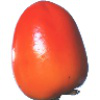

In [12]:
img_show

Pour la suite nous utiliserons le modèle MobileNetV2, je ne vais pas ici remontrer l'architecture de ce dernier puisque ça a déjà été fait.

Comme pour la version avec le chargement des images locales, nous allons charger nos images au format binary:

Afin de lire des fichiers binaires à partir d’Amazon S3 en utilisant le préfixe ci-dessous au chemin d’accès:

    - s3:\\ = > Première génération
    - s3n:\\ => deuxième génération
    - s3a:\\ => Troisième génération
    
Dans notre cas nous sommes à la 3ème génération, donc nous préfixerons le chemin de nos images avec 's3a:\\\\' .

Ainsi que des dépendances et des informations d’identification tierces, dans notre cas nous devrons charger les .jars suivant:

    - org.apache.hadoop:hadoop-aws:3.2.0
    - com.amazonaws:aws-java-sdk-core-1.12.134
    - com.amazonaws:aws-java-sdk-dynamodb-1.12.134

In [13]:
img_dirS3 = 's3a://imageprojet8oc/ImageAWS/*'

In [14]:
sc = spark.sparkContext
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
sc._jsc.hadoopConfiguration().set('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')
#sc._jsc.hadoopConfiguration().set('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.12.117')
#sc._jsc.hadoopConfiguration().set('spark.jars.packages', 'com.amazonaws:aws-java-sdk-s3-1.12.120')
sc._jsc.hadoopConfiguration().set('spark.jars.packages', 'com.amazonaws:aws-java-sdk-core-1.12.134')
sc._jsc.hadoopConfiguration().set('spark.jars.packages', 'com.amazonaws:aws-java-sdk-dynamodb-1.12.134')
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.eu-west-3.amazonaws.com")
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", AWS_KEY)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", SEC_KEY)

In [15]:
imagesALL_df = spark.read.format("binaryFile") \
                    .option("pathGlobFilter", "*.jpg") \
                    .option("recursiveFileLookup", "true") \
                    .load(img_dirS3)

In [16]:
imagesALL_df.show(5)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://imageprojet...|2022-01-16 23:06:32|  6307|[FF D8 FF E0 00 1...|
|s3a://imageprojet...|2022-01-16 23:03:34|  6298|[FF D8 FF E0 00 1...|
|s3a://imageprojet...|2022-01-16 23:06:20|  6295|[FF D8 FF E0 00 1...|
|s3a://imageprojet...|2022-01-16 23:06:23|  6295|[FF D8 FF E0 00 1...|
|s3a://imageprojet...|2022-01-16 23:06:13|  6290|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows



In [17]:
imagesALL_df.select('path').show(5, False)

+------------------------------------------------+
|path                                            |
+------------------------------------------------+
|s3a://imageprojet8oc/ImageAWS/Lychee/168_100.jpg|
|s3a://imageprojet8oc/ImageAWS/Lychee/194_100.jpg|
|s3a://imageprojet8oc/ImageAWS/Lychee/186_100.jpg|
|s3a://imageprojet8oc/ImageAWS/Lychee/192_100.jpg|
|s3a://imageprojet8oc/ImageAWS/Lychee/172_100.jpg|
+------------------------------------------------+
only showing top 5 rows



Nous allons maintenant chercher à récupérer les labels pour chaques images:

In [18]:
from pyspark.sql.functions import split

In [19]:
labelAll0 = imagesALL_df.withColumn("Label0", split(imagesALL_df['path'], "//").getItem(1))

In [20]:
labelAll0.select('Label0').show(1, False)

+------------------------------------------+
|Label0                                    |
+------------------------------------------+
|imageprojet8oc/ImageAWS/Lychee/168_100.jpg|
+------------------------------------------+
only showing top 1 row



In [21]:
imagesALL_dfLabel = labelAll0.withColumn("Label", split(labelAll0['Label0'], "/").getItem(2))

In [22]:
imagesALL_dfLabel = imagesALL_dfLabel.select('path', 'content', 'Label')

In [23]:
imagesALL_dfLabel.show(1)

+--------------------+--------------------+------+
|                path|             content| Label|
+--------------------+--------------------+------+
|s3a://imageprojet...|[FF D8 FF E0 00 1...|Lychee|
+--------------------+--------------------+------+
only showing top 1 row



In [24]:
imagesALL_dfLabel.groupBy("Label").count().show()

+----------+-----+
|     Label|count|
+----------+-----+
|Grape_Blue|  245|
|Strawberry|  245|
|      Kaki|  245|
|    Lychee|  245|
+----------+-----+



Récpérons maintenant l'index des différents Label:

In [25]:
label_indexer = StringIndexer(inputCol="Label", outputCol="Label_index")
label_indexer_transformer = label_indexer.fit(imagesALL_dfLabel)
imagesALL_dfLabel = label_indexer_transformer.transform(imagesALL_dfLabel)

In [26]:
imagesALL_dfLabel.show(1)

+--------------------+--------------------+------+-----------+
|                path|             content| Label|Label_index|
+--------------------+--------------------+------+-----------+
|s3a://imageprojet...|[FF D8 FF E0 00 1...|Lychee|        2.0|
+--------------------+--------------------+------+-----------+
only showing top 1 row



Nous avons bien récupérer l'index des labels de nos images, passons à la suite.

Commencons par prétraiter nos images, en les redimmensionnant. Ce redimmensionnement se fera à l'appel de l'image, nous aurions pu transformer nos images directement et les enregistrer dans un nouveau dossier, mais cela prendrait trop de temps et surtout si la base de données change il faudra retransformer ces images "à la main".

In [27]:
def preprocess(content):
    image = PIL.Image.open(io.BytesIO(content))
    imageResize = image.resize([224, 224])
    imageArray = img_to_array(imageResize)
    preprocessingImage = preprocess_input(imageArray)
    return preprocessingImage

Nous utiliserons les poids de ImageNet, le modèle a déjà était entraîné sur des images de fruits, donc il n'y aurait pas d'intérêt à refaire un entraînement depuis le début.

In [28]:
def model_MobileNetV2():
    model = MobileNetV2(include_top = False, input_shape=(224, 224, 3), weights = "imagenet", pooling = 'max')
    return model

Nous allons maintenant récupérer les features de chaques images:

In [29]:
def featurize_series(model, content_series):
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [30]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    model = model_MobileNetV2()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

C:\Spark\spark-3.1.2-bin-hadoop3.2\python\pyspark\sql\pandas\functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [31]:
features_df = imagesALL_dfLabel.select("path", 'Label', 'Label_index', featurize_udf("content"))

Afin d'optimiser notre code nous allons enregistrer features_df en mémoire, ça nous permettra d'éviter de réaliser des actions deux fois (ici l'appel à featurize_udf):

In [32]:
features_df.persist()

DataFrame[path: string, Label: string, Label_index: double, featurize_udf(content): array<float>]

In [33]:
features_df.show(1)

+--------------------+------+-----------+----------------------+
|                path| Label|Label_index|featurize_udf(content)|
+--------------------+------+-----------+----------------------+
|s3a://imageprojet...|Lychee|        2.0|  [5.899542, 6.0, 0...|
+--------------------+------+-----------+----------------------+
only showing top 1 row



In [34]:
features_df = features_df.withColumnRenamed("featurize_udf(content)", "Features")

In [35]:
features_df.show(1)

+--------------------+------+-----------+--------------------+
|                path| Label|Label_index|            Features|
+--------------------+------+-----------+--------------------+
|s3a://imageprojet...|Lychee|        2.0|[5.899542, 6.0, 0...|
+--------------------+------+-----------+--------------------+
only showing top 1 row



Regardons le forme de nos données Features:

In [36]:
featurefd = features_df.select('Features')

In [37]:
featurefd_Panda = featurefd.toPandas()

In [38]:
len(featurefd_Panda['Features'][0])

1280

Nous devons convertir nos features au format 'org.apache.spark.ml.linalg.VectorUDT' dans un premier temps, pour pouvoir utiliser l'ACP de Pyspark:

In [39]:
from pyspark.ml.feature import PCA

In [40]:
conversionVectorUDT = udf(lambda feature: Vectors.dense(feature), VectorUDT())

In [41]:
features_df = features_df.withColumn("VectorUdt", conversionVectorUDT('Features'))

In [42]:
features_df.show(1)

+--------------------+------+-----------+--------------------+--------------------+
|                path| Label|Label_index|            Features|           VectorUdt|
+--------------------+------+-----------+--------------------+--------------------+
|s3a://imageprojet...|Lychee|        2.0|[5.899542, 6.0, 0...|[5.89954185485839...|
+--------------------+------+-----------+--------------------+--------------------+
only showing top 1 row



In [43]:
acp_train, acp_test = features_df.randomSplit([0.7, 0.3], seed = 7)

Pour la suite nous allons réduire la dimension de nos données, nous avons tracer la courbe d'inertie, nous avons dans un premier temps pris un nombre élevé pour k, nous avons pris k = 75, puis nous avons tracer la courbe, le code sera donné en commentaire mais ne sera pas utiliser ici, nous afficherons la courbe:

In [44]:
#pca = PCA(k = 75, inputCol = 'VectorUdt', outputCol = 'X_acp')
#model = pca.fit(acp_train)
#acp_df = model.transform(acp_train)

#nombreK = 0
#somme = 0
#listeI = []
#listeSomme = []
#for i in range(len(model.explainedVariance)):
#    if somme < 0.75:
#        somme = somme + model.explainedVariance[i]
#        listeI.append(i)
#        listeSomme.append(somme)
#        nombreK += 1
#
#print(somme)
#print(nombreK)

#import matplotlib.pyplot as plt
#plt.plot(listeI, listeSomme)
#plt.show()

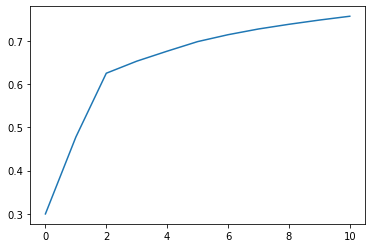

Pour la suite, à la vue de ce graphe nous prendrons donc k = 2, d'après la méthode du coude.

In [45]:
pca = PCA(k = 2, inputCol = 'VectorUdt', outputCol = 'X_acp')
model = pca.fit(acp_train)
acp_df = model.transform(acp_train)

In [46]:
acp_df.show(1)

+--------------------+------+-----------+--------------------+--------------------+--------------------+
|                path| Label|Label_index|            Features|           VectorUdt|               X_acp|
+--------------------+------+-----------+--------------------+--------------------+--------------------+
|s3a://imageprojet...|Lychee|        2.0|[5.502656, 6.0, 0...|[5.50265598297119...|[-38.764044931983...|
+--------------------+------+-----------+--------------------+--------------------+--------------------+
only showing top 1 row



Nous pouvons maintenant passer à la classification après un entraînement:

In [47]:
lr = LogisticRegression(maxIter = 20, regParam = 0.05, elasticNetParam = 0.3, labelCol = "Label_index", featuresCol = 'X_acp')
p_model = lr.fit(acp_df)

In [48]:
acp_Train = model.transform(acp_train)
predictions1 = p_model.transform(acp_Train)

In [49]:
predictions1.select("path", "Label", "Label_index", "prediction").show(45, False)

+------------------------------------------------+------+-----------+----------+
|path                                            |Label |Label_index|prediction|
+------------------------------------------------+------+-----------+----------+
|s3a://imageprojet8oc/ImageAWS/Lychee/134_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/137_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/164_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/167_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/169_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/171_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/175_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/177_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/184_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageA

In [50]:
evaluatorF1 = MulticlassClassificationEvaluator(labelCol = "Label_index", predictionCol = "prediction", metricName = "f1")

In [51]:
print("F1 = ", evaluatorF1.evaluate(predictions1))

F1 =  1.0


In [52]:
evaluatorAccuracy = MulticlassClassificationEvaluator(labelCol = "Label_index", predictionCol = "prediction", metricName = "accuracy")

In [53]:
print("Accuracy = ", evaluatorAccuracy.evaluate(predictions1))

Accuracy =  1.0


Regardons maintenant sur les donées de test:

In [54]:
acp_Test = model.transform(acp_test)
predictions = p_model.transform(acp_Test)

In [55]:
predictions.select("path", "Label", "Label_index", "prediction").show(45, False)

+------------------------------------------------+------+-----------+----------+
|path                                            |Label |Label_index|prediction|
+------------------------------------------------+------+-----------+----------+
|s3a://imageprojet8oc/ImageAWS/Lychee/138_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/168_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/170_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/172_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/173_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/176_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/183_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/186_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageAWS/Lychee/188_100.jpg|Lychee|2.0        |2.0       |
|s3a://imageprojet8oc/ImageA

Nous pouvons voir que des erreurs existe, ce qui n'est pas étonnant à la vue des classes que nous avons prises.

Pour évaluer notre classification multi-classes, nous utiliserons un modèle qui évaluera les prédictions. Nous utiliserons MulticlassClassificationEvaluator avec les métriques F1 et Accuracy.

F1 est une moyenne pondérée des scores de précision et de rappel qui sont:

    - Précision : Correspond au nombre d'images correctement attribuées à la classe i par rapport au nombre total d'images       prédites comme appartenant à la classe i.
    
    - Rappel : Correspond au nombre d'images correctement attribuées à la classe i par rapport au nombre total d'images           appartenant à la classe i.   
    
La mesure F1 est à préférer si nos données sont déséquilibrées, ici ce ne sera pas le cas car nos classes ont un nombre d'images assez proche, comme nous allons voir, mais nous ne savons pas ce qu'il en sera demain et c'est pour cette raison nous évaluerons la précision et F1.

In [56]:
predictions.groupBy("Label").count().show()

+----------+-----+
|     Label|count|
+----------+-----+
|Grape_Blue|   76|
|Strawberry|   61|
|      Kaki|   63|
|    Lychee|   85|
+----------+-----+



Nous pouvons voir que la classe Mangoustan est assez déséquilibrée par rapport aux autres, la métrique F1 trouve son intérêt ici.

In [57]:
evaluatorF1 = MulticlassClassificationEvaluator(labelCol = "Label_index", predictionCol = "prediction", metricName = "f1")

In [58]:
print("F1 = ", evaluatorF1.evaluate(predictions))

F1 =  1.0


In [59]:
evaluatorAccuracy = MulticlassClassificationEvaluator(labelCol = "Label_index", predictionCol = "prediction", metricName = "accuracy")

In [60]:
print("Accuracy = ", evaluatorAccuracy.evaluate(predictions))

Accuracy =  1.0


Nous pouvons voir que nos résultats sont très bons puisque nos images sont parfaitement classées, ce qui est logique au final puisque les classes sont très différentes.

Mais si d'aventure nous obtenions des résultats moyen, nous pourrions utiliser les fonctions ParamGridBuilder et CrossValidator, qui vont correspondre aux classes GridSearchCV et CrossValidation de python (en faisant un rapide raccourci).

Nous nous focaliserions sur la métrique F1 pour les raisons évoquées plus haut.

In [61]:
#paramGrid = (ParamGridBuilder()
#  .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
#  .addGrid(lr.maxIter, [10, 20, 50]) \
#  .addGrid(lr.elasticNetParam, [0.0, 0.8]) \
#  .build())

In [62]:
#crossval = CrossValidator(estimator = lr,
#                          estimatorParamMaps = paramGrid,
#                          evaluator = evaluatorF1,
#                          numFolds = 3)

In [63]:
#modelOpt = crossval.fit(acp_train)

In [64]:
#predictionsOpt = modelOpt.transform(acp_test)

In [65]:
#print("F1 Opt = ", evaluatorF1.evaluate(predictionsOpt))

Les 2 fonctions devraient opérer une amélioration, nous pourrions peut être l'améliorer encore un peu en choisissant plus de paramètre a tester. Si aucune amélioration n'est réalisé il faudrait réfléchir à utiliser un autre modèle, fournir plus d'image d'entraînement ou revoir votre méthode.

Nous allons convertir notre fichier au format Pandas afin que nous puissions l'utiliser aussi bien en pyspark qu'en python à l'avenir si besoin.

Récupérons dans un premier temps l'adresse du dossier de résultat. Nous utiliserons une nouvelle fois 's3a://' pour accéder au dossier:

In [66]:
resultat_dir = 's3a://imageprojet8oc/resultat/'

In [67]:
resultattoPandas = predictions.toPandas()

In [68]:
resultattoPandas.head()

,path,Label,Label_index,Features,VectorUdt,X_acp,rawPrediction,probability,prediction
0,s3a://imageprojet8oc/ImageAWS/Lychee/138_100.jpg,Lychee,2.0,"[6.0, 6.0, 0.0, 0.0, 0.0, 0.0, 1.2470893859863...","[6.0, 6.0, 0.0, 0.0, 0.0, 0.0, 1.2470893859863...","[-38.21556039642781, -2.9845226576518264]","[-0.5940715083834257, -2.0947826501635456, 1.9...","[0.057220457988209926, 0.012758533601474227, 0...",2.0
1,s3a://imageprojet8oc/ImageAWS/Lychee/168_100.jpg,Lychee,2.0,"[5.899541854858398, 6.0, 0.0, 0.0, 0.005040168...","[5.899541854858398, 6.0, 0.0, 0.0, 0.005040168...","[-38.404451165085405, -4.8425670906523095]","[-0.5442814313648258, -2.1996719915121323, 2.0...","[0.05650213015354228, 0.010792892105981245, 0....",2.0
2,s3a://imageprojet8oc/ImageAWS/Lychee/170_100.jpg,Lychee,2.0,"[4.7932586669921875, 6.0, 0.0, 0.0, 0.0, 2.465...","[4.7932586669921875, 6.0, 0.0, 0.0, 0.0, 2.465...","[-37.8919829556127, -4.104653537854926]","[-0.5482549938613935, -2.1478075003315404, 1.9...","[0.058314259054227456, 0.011778715572324726, 0...",2.0
3,s3a://imageprojet8oc/ImageAWS/Lychee/172_100.jpg,Lychee,2.0,"[4.484482765197754, 6.0, 0.0, 0.0, 0.0, 0.7102...","[4.484482765197754, 6.0, 0.0, 0.0, 0.0, 0.7102...","[-38.102428854778296, -3.735262137494534]","[-0.5671110683435229, -2.1327420095989407, 1.9...","[0.05760185002735362, 0.012036259808208442, 0....",2.0
4,s3a://imageprojet8oc/ImageAWS/Lychee/173_100.jpg,Lychee,2.0,"[4.615333557128906, 6.0, 0.0, 0.0, 0.0, 0.7182...","[4.615333557128906, 6.0, 0.0, 0.0, 0.0, 0.7182...","[-37.69734099271417, -5.361362452073927]","[-0.5029341223213685, -2.211227161362889, 2.02...","[0.05887957371640522, 0.010667494233172805, 0....",2.0


In [69]:
csv_buffer = StringIO()
resultattoPandas.to_csv(csv_buffer)
s3.Object('imageprojet8oc', 'resultat/resultat.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '0CN07PGTH1GKPEFG',
  'HostId': 'pqPNP+o1z9bNiveLcs5JZzN9rcI7fKNfJZhT9rXa2BTXmdu13WZxOvN0Ytl73EPQv9BYQYhZrq0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'pqPNP+o1z9bNiveLcs5JZzN9rcI7fKNfJZhT9rXa2BTXmdu13WZxOvN0Ytl73EPQv9BYQYhZrq0=',
   'x-amz-request-id': '0CN07PGTH1GKPEFG',
   'date': 'Tue, 18 Jan 2022 21:10:27 GMT',
   'etag': '"1474b8e50b5a8d561d11bce90dda066a"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1474b8e50b5a8d561d11bce90dda066a"'}

Nous allons enregistrer le modèle et la fonction de prédiction lr, nous pourrons par la suite les récupérer directement et gagner un peu de temps:

In [70]:
s3.Object('imageprojet8oc', 'resultat/model.pkl').put(Body = 'model')
s3.Object('imageprojet8oc', 'resultat/classificationLR.pkl').put(Body = 'lr')

{'ResponseMetadata': {'RequestId': 'DS08FJTTFWAX3CQ9',
  'HostId': 'PsC98ZYfNmhhu7oG8vWY2v+mkIJAw4I+rAkP1rFlT0JPXXZf3jhwaWFh8vBpyX3nyv0LqlZrGM4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'PsC98ZYfNmhhu7oG8vWY2v+mkIJAw4I+rAkP1rFlT0JPXXZf3jhwaWFh8vBpyX3nyv0LqlZrGM4=',
   'x-amz-request-id': 'DS08FJTTFWAX3CQ9',
   'date': 'Tue, 18 Jan 2022 21:10:31 GMT',
   'etag': '"58791f322c1bfc3de6141788d3b8666f"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"58791f322c1bfc3de6141788d3b8666f"'}

## Validation

Nous allons nous attaquer à la partie test, nous avons entraîné nos modèles avec des images à notre disposition, mais nous devons maintenant gérer les nouvelles images qui arriveront, pour cela nous ferons appel à ce que nous avons déjà vu, comme le preprocessing de l'image (modifier la taille de l'image notamment), récupérer les features de l'image et enfin la classifier.

C'est ce que nous utiliserons si nous devions par la suite classer de nouvelles images.

Commencons par charger nos images de test:

In [71]:
img_dir = 's3://imageprojet8octest/ImageAWSTest/'
s3 = boto3.resource('s3')
bucket = s3.Bucket("imageprojet8oc")
#key = boto.s3.key.Key(bucket, "words.txt")

print('dataset_path =', img_dir)  

dataset_path = s3://imageprojet8octest/ImageAWSTest/


In [72]:
img_dirS3Test = 's3a://imageprojet8octest/ImageAWSTest/*'

In [73]:
sc = spark.sparkContext
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
sc._jsc.hadoopConfiguration().set('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')
#sc._jsc.hadoopConfiguration().set('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.12.117')
#sc._jsc.hadoopConfiguration().set('spark.jars.packages', 'com.amazonaws:aws-java-sdk-s3-1.12.120')
sc._jsc.hadoopConfiguration().set('spark.jars.packages', 'com.amazonaws:aws-java-sdk-core-1.12.134')
sc._jsc.hadoopConfiguration().set('spark.jars.packages', 'com.amazonaws:aws-java-sdk-dynamodb-1.12.134')
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.eu-west-3.amazonaws.com")
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", AWS_KEY)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", SEC_KEY)

In [74]:
imagesALL_dfTest = spark.read.format("binaryFile") \
                    .option("pathGlobFilter", "*.jpg") \
                    .option("recursiveFileLookup", "true") \
                    .load(img_dirS3Test)

In [75]:
imagesALL_dfTest.show(1)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://imageprojet...|2022-01-12 20:41:16|  5889|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 1 row



In [76]:
labelAll0Test = imagesALL_dfTest.withColumn("Label0", split(imagesALL_dfTest['path'], "//").getItem(1))
imagesALL_dfLabelTest = labelAll0Test.withColumn("Label", split(labelAll0Test['Label0'], "/").getItem(2))
imagesALL_dfLabelTest = imagesALL_dfLabelTest.select('path', 'content', 'Label')

In [77]:
imagesALL_dfLabelTest.show(1)

+--------------------+--------------------+------+
|                path|             content| Label|
+--------------------+--------------------+------+
|s3a://imageprojet...|[FF D8 FF E0 00 1...|Lychee|
+--------------------+--------------------+------+
only showing top 1 row



In [78]:
label_indexerTest = StringIndexer(inputCol="Label", outputCol="Label_index")
label_indexer_transformerTest = label_indexerTest.fit(imagesALL_dfLabelTest)
imageTest_dfLabelTest = label_indexer_transformerTest.transform(imagesALL_dfLabelTest)

In [79]:
imageTest_dfLabelTest.show(1)

+--------------------+--------------------+------+-----------+
|                path|             content| Label|Label_index|
+--------------------+--------------------+------+-----------+
|s3a://imageprojet...|[FF D8 FF E0 00 1...|Lychee|        2.0|
+--------------------+--------------------+------+-----------+
only showing top 1 row



In [80]:
def preprocessTest(content):
    image = PIL.Image.open(io.BytesIO(content))
    imageResize = image.resize([224, 224])
    imageArray = img_to_array(imageResize)
    preprocessingImage = preprocess_input(imageArray)
    return preprocessingImage

In [81]:
def model_MobileNetV2():
    model = MobileNetV2(include_top = False, input_shape=(224, 224, 3), weights = "imagenet", pooling = 'max')
    return model

In [82]:
def featurize_seriesX(model, content_series):
    input = np.stack(content_series.map(preprocessTest))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [83]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udfX(content_series_iter):
    model = model_MobileNetV2()
    for content_series in content_series_iter:
        yield featurize_seriesX(model, content_series)

C:\Spark\spark-3.1.2-bin-hadoop3.2\python\pyspark\sql\pandas\functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [84]:
features_dfTest = imageTest_dfLabelTest.select("path", 'Label', 'Label_index', featurize_udfX("content"))

In [85]:
features_dfTest.persist()

DataFrame[path: string, Label: string, Label_index: double, featurize_udfX(content): array<float>]

In [86]:
features_dfTest = features_dfTest.withColumnRenamed("featurize_udfX(content)", "Features")

In [87]:
features_dfTest = features_dfTest.withColumn("VectorUdt", conversionVectorUDT('Features'))

In [88]:
features_dfTest.show(1)

+--------------------+------+-----------+--------------------+--------------------+
|                path| Label|Label_index|            Features|           VectorUdt|
+--------------------+------+-----------+--------------------+--------------------+
|s3a://imageprojet...|Lychee|        2.0|[6.0, 6.0, 1.7463...|[6.0,6.0,1.746314...|
+--------------------+------+-----------+--------------------+--------------------+
only showing top 1 row



In [89]:
acp_dfTest = model.transform(features_dfTest)

In [90]:
acp_dfTest.show(1)

+--------------------+------+-----------+--------------------+--------------------+--------------------+
|                path| Label|Label_index|            Features|           VectorUdt|               X_acp|
+--------------------+------+-----------+--------------------+--------------------+--------------------+
|s3a://imageprojet...|Lychee|        2.0|[6.0, 6.0, 1.7463...|[6.0,6.0,1.746314...|[-35.893827514993...|
+--------------------+------+-----------+--------------------+--------------------+--------------------+
only showing top 1 row



In [91]:
predictions = p_model.transform(acp_dfTest)

In [92]:
interval = time.time() - start_time
print('Total time in seconds:', interval)

Total time in seconds: 975.4612152576447
